In [1]:
# Dependencies
import json
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

# Local dependencies
from modules.dataset.tweets import Tweets
from modules.dataset.entities import Entities

# Constants
alpha = 0.85
max_iter = 100
data_path = "data/communities/"

In [2]:
def get_adjacency_matrix(data):
    """
    Input:
        - data: pandas.DataFrame with columns names = ['index_id', 'index_tag']
    Output:
        - numpy.matrix A - Adjacency matrix
    """
    # Create networkx graph object
    graph = nx.from_pandas_edgelist(data, source='index_id', target='index_tag')
    # Check if the graph is connected
    cc = nx.number_connected_components(graph)
    if cc > 1:
        print('The bipartite graph is not connected! The GC will be used')
        # Extract giant component
        giant = max(nx.connected_component_subgraphs(graph), key=len)
        # Select the GC
        graph = graph.subgraph(giant)
    # Extract adjacency matrix
    A = nx.to_numpy_matrix(graph)
    #print(A.shape)
    return A

In [3]:
def get_google_matrix(A, e2i, cluster, alpha):
    """
    Input:
        - A       : numpy.matrix of dimension [n_nodes, n_nodes]
        - e2i     : dictionary that associates each node name to its number in the graph
        - cluster : list of strings (node names)
        - alpha   : float between 0 and 1 -- Dumping factor (which is 1 - teleport probability)
    Output:
        - numpy.matrix - Google matrix G = alpha A + (1-alpha) C
    """
    # Normalize A (stochastic on columns)
    A /= A.sum(axis=0)
    # Mask of indices in the cluster
    mask = [ e2i[e] for e in cluster ]
    # Compute google matrix
    G = alpha*A
    G[mask, :] += (1-alpha)/len(cluster)

    return G

In [4]:
def power_iteration(G, max_iter: int, tolerance=1e-6):
    """
    Input:
        - G         : squared numpy.matrix -- Google matrix
        - max_iter  : int -- maximum number of iterations
        - tolerance : float -- maximum accepted error
    Output:
        - approximate eigenvector of G (unique if G is a Google matrix)
    """
    # Choose a random vector to decrease the chance that our vector is orthogonal to the eigenvector
    b_k = np.random.rand(G.shape[1])

    for _ in range(max_iter):
        # Calculate the matrix-by-vector product Ab
        b_k1 = G @ np.reshape(b_k, (-1,1)) 

        # Calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # Re-normalize the vector
        b_k = b_k1 / b_k1_norm

        # If the precision increment is uniformly lower than the tolerance, break
        if np.allclose(b_k, b_k1, atol=tolerance):
            #print(b_k1_norm)
            break

    return b_k

In [5]:
# Load communities data
communities = pd.read_csv(data_path+"hashtags_community_selected.csv", header=0)

# Load tweet_id - hashtag map
hashtags = Entities()
hashtags.from_json("data/db/hashtags.json")
hashtags.df = hashtags.df[['tweet_id','entity_text']].rename(columns={'entity_text': 'hashtag'})
hashtags.df.hashtag = hashtags.df.hashtag.apply(lambda x: x.lower())
# Drop rows with search hashtags
seed_list = ["#climatechange", "#climate", "#sdgs", "#sustainability", "#environment", "#globalwarming"]
hashtags.df = hashtags.df[~hashtags.df.hashtag.isin(seed_list)]

# Load tweet data
tweets = Tweets()
tweets.from_json("data/db/tweets.json")

In [6]:
years = set(communities.year.values)

for year in years:    
    # Select ids of the year
    curr_ids = list(tweets.df.tweet_id[tweets.df.tweet_date.dt.year == year].values)
    # Select communities of the year
    curr_communities = communities[communities.year == year]
    # Select hashtags of interest
    data = hashtags.df[hashtags.df.tweet_id.isin(curr_ids)]
    
    # Map entities in index
    nodes = list(data.hashtag.unique())
    nodes.extend(data.tweet_id.unique())
    e2i = dict(zip(nodes, range(len(nodes))))
    # Map index in entities
    i2e = dict(zip(range(len(nodes)), nodes))

    # Add indices to data
    data['index_id'] = data.tweet_id.apply(lambda x: e2i[x])
    data['index_tag'] = data.hashtag.apply(lambda x: e2i[x])
    # Keep only indices
    data = data[['index_id', 'index_tag']]
    
    # Init metrics container for year
    clusters = curr_communities.community.unique()
    community_similarity = pd.DataFrame(columns=clusters, dtype=float)
    
    print("Network {:d}".format(year), end='\n\n')
    
    # Compute adjacency matrix
    A = get_adjacency_matrix(data)    
    print("det(A): ", np.linalg.det(A))
    # Loop through communities
    for cluster in clusters:
        # Compute Google matrix
        G = get_google_matrix(A, e2i, curr_communities.hashtag[curr_communities.community == cluster], alpha)
        # Compute eigenvector
        v = power_iteration(G, 100)
        # Add eigenvector to metrics container
        community_similarity[cluster] = np.array(v).squeeze()
    print()    
    # Remove hashtag from nodes
    community_similarity.index = pd.Series(community_similarity.index).apply(lambda x: i2e[x])
    mask_tweets = community_similarity.index.isin(curr_ids)
    community_similarity = community_similarity.loc[mask_tweets]

    # Save results
    community_similarity.to_csv(data_path+"tweet_communities{}.csv".format(year))

/home/laura/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/laura/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Network 2017

The bipartite graph is not connected! The GC will be used
det(A):  0.0

Network 2018

The bipartite graph is not connected! The GC will be used
det(A):  0.0

Network 2019

The bipartite graph is not connected! The GC will be used
det(A):  0.0



## Visualization

In [7]:
year = 2019

community_similarity = pd.read_csv(data_path+"tweet_communities{}.csv".format(year), index_col=0,
                                   dtype={'index': np.unicode_})
community_similarity.head(10)

,0,1,2,3,9,12,15
1101574442575167489,0.000365,0.002733,0.000617,0.000358,0.002132,0.000383,0.001200
1101574446341607424,0.000210,0.001795,0.000591,0.000660,0.005836,0.000259,0.000251
1101574476297314311,0.000511,0.000660,0.000511,0.000524,0.000587,0.000398,0.000638
1101574488225918976,0.002658,0.001162,0.000343,0.000286,0.001091,0.000259,0.001008
1101574491430375428,0.001365,0.001869,0.001932,0.002736,0.002144,0.001328,0.001798
1101574513450459138,0.000386,0.000530,0.000557,0.000773,0.000607,0.000389,0.000509
1101574525622329344,0.008264,0.000432,0.000295,0.001051,0.000963,0.000542,0.000341
1101574533465681920,0.003511,0.000184,0.000147,0.000444,0.000409,0.000249,0.000145
1101574542147780609,0.001459,0.002009,0.001602,0.001908,0.002060,0.003311,0.001494
1101574542261141506,0.000309,0.000427,0.000345,0.000404,0.000438,0.000710,0.000317


/home/laura/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


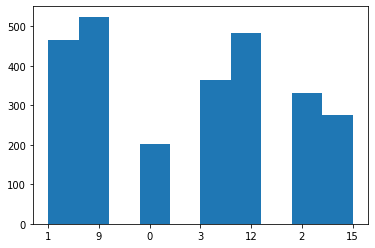

In [8]:
# Distribution of tweets in communities
comm_list = community_similarity.apply(lambda x: np.argmax(x), axis=1)
plt.hist(comm_list.values)
plt.show()

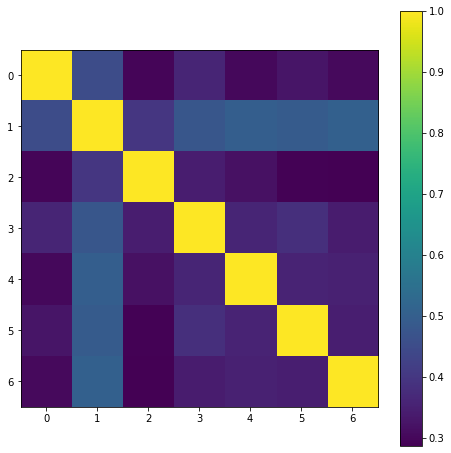

In [9]:
# Correlation matrix
fig, axs = plt.subplots(1, 1, figsize=(8,8))
axs.imshow(community_similarity.corr())
plt.colorbar(axs.imshow(community_similarity.corr()))
plt.show()

In [11]:
# check numbero of duplicates in row
df = community_similarity.copy()
(community_similarity.shape[0] - df.drop_duplicates().shape[0] )/community_similarity.shape[0]

0.4641238670694864

## Other useful data

In [12]:
# Save networks only with the hashtags in a community (selected)

years = set(communities.year.values)
for year in years:
    # Select ids of the year
    curr_ids = list(tweets.df.tweet_id[tweets.df.tweet_date.dt.year == year].values)
    # Select communities of the year
    curr_communities = communities[communities.year == year]
    # Select hashtags of interest
    curr_hashtags = hashtags.df[(hashtags.df.tweet_id.isin(curr_ids)) & (hashtags.df.hashtag.isin(curr_communities.hashtag.unique())) ]
    # Initialize net class
    curr_edges = pd.merge(curr_hashtags, curr_hashtags, on='tweet_id')
    curr_edges = curr_edges[['hashtag_x', 'hashtag_y']]
    # Discard self loops
    self_loops = curr_edges.apply(lambda x: x.hashtag_x == x.hashtag_y, axis = 1)
    curr_edges = curr_edges[~self_loops]
    # Define net
    curr_net= nx.from_pandas_edgelist(curr_edges, source='hashtag_x', target='hashtag_y')
    # Save net
    nx.write_gexf(curr_net, 'data/communities/hash_net_communities_{}.gexf'.format(year))

In [15]:
# Rename columns with the communities labels

years = set(communities.year.values)
# Import name-id map
labels = pd.read_csv("data/communities/name_index_community_map.csv", dtype=str)

for year in years:
    # Import files
    community_similarity = pd.read_csv(data_path+"tweet_communities{}.csv".format(year), index_col=0,
                                   dtype={'index': np.unicode_})

    # Define dict {cluster_id : cluster_label}
    id2name = labels.loc[labels.year==str(year), ["label", "index"]].set_index("index", drop=True)
    id2name = id2name.to_dict()["label"]
    
    # Rename columns using community names
    community_similarity = community_similarity.rename(columns=id2name)
    community_similarity.to_csv(data_path+"tweet_communities{}.csv".format(year))

In [16]:
# Show last computed result
community_similarity.head()

,sustainable_development,greta,endangered_habitats,innovation,renewable_energy,mixed,developement_goals
1101574442575167489,0.000365,0.002733,0.000617,0.000358,0.002132,0.000383,0.001200
1101574446341607424,0.000210,0.001795,0.000591,0.000660,0.005836,0.000259,0.000251
1101574476297314311,0.000511,0.000660,0.000511,0.000524,0.000587,0.000398,0.000638
1101574488225918976,0.002658,0.001162,0.000343,0.000286,0.001091,0.000259,0.001008
1101574491430375428,0.001365,0.001869,0.001932,0.002736,0.002144,0.001328,0.001798
